
# Semana 6 — MLP (Multi-Layer Perceptron) 🧠✨

Neste notebook você vai:
1) Treinar um **MLPClassifier** do scikit-learn em dados 2D.  
2) Comparar com o Perceptron (fronteira linear).  
3) Brincar com **camadas ocultas**, **funções de ativação**, **regularização** e **early stopping**.  
4) Ver **fronteiras de decisão** e **curvas de aprendizado**.


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss


## 1) Dados 2D — caso separável de leve

In [2]:

X, y = make_classification(
    n_samples=800, n_features=2, n_informative=2, n_redundant=0,
    n_clusters_per_class=1, class_sep=1.2, random_state=42
)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr)
X_te_s = scaler.transform(X_te)

print("Shapes:", X_tr_s.shape, X_te_s.shape)


Shapes: (600, 2) (200, 2)


## 2) Baseline: Perceptron (fronteira linear)

In [3]:

percep = Perceptron(max_iter=1000, tol=1e-3, random_state=42).fit(X_tr_s, y_tr)
acc_p = accuracy_score(y_te, percep.predict(X_te_s))
print(f"Acurácia Perceptron: {acc_p:.3f}")


Acurácia Perceptron: 0.890


## 3) MLP básico

In [4]:

mlp = MLPClassifier(hidden_layer_sizes=(16,), activation="relu",
                    solver="adam", alpha=1e-4, batch_size=32,
                    learning_rate="adaptive", learning_rate_init=1e-3,
                    max_iter=300, random_state=42, early_stopping=True,
                    n_iter_no_change=10, validation_fraction=0.1, verbose=False)
mlp.fit(X_tr_s, y_tr)

y_hat = mlp.predict(X_te_s)
proba = mlp.predict_proba(X_te_s)
acc = accuracy_score(y_te, y_hat)
ll  = log_loss(y_te, proba)
print(f"Acurácia MLP: {acc:.3f} | LogLoss: {ll:.3f}")
print("Matriz de confusão:\n", confusion_matrix(y_te, y_hat))
print("\nRelatório:\n", classification_report(y_te, y_hat))


Acurácia MLP: 0.905 | LogLoss: 0.546
Matriz de confusão:
 [[91  9]
 [10 90]]

Relatório:
               precision    recall  f1-score   support

           0       0.90      0.91      0.91       100
           1       0.91      0.90      0.90       100

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.90       200
weighted avg       0.91      0.91      0.90       200



## 4) Fronteira de decisão — Perceptron vs MLP

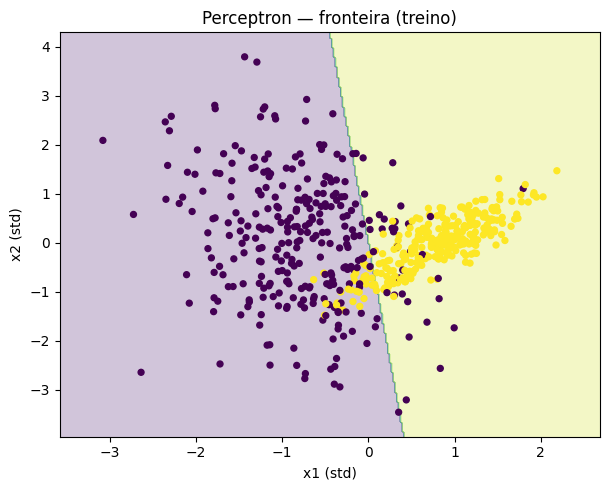

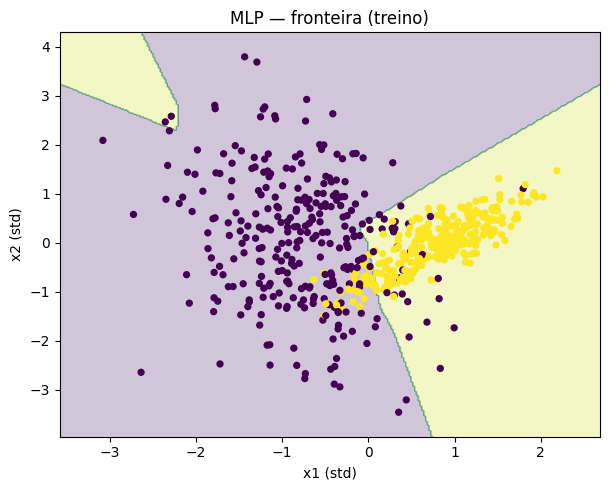

In [5]:

def plot_boundary(model, X, y, title=""):
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.figure(figsize=(6.2,5))
    plt.contourf(xx, yy, Z, alpha=0.25)
    plt.scatter(X[:,0], X[:,1], c=y, s=18)
    plt.title(title); plt.xlabel("x1 (std)"); plt.ylabel("x2 (std)")
    plt.tight_layout(); plt.show()

plot_boundary(percep, X_tr_s, y_tr, "Perceptron — fronteira (treino)")
plot_boundary(mlp,    X_tr_s, y_tr, "MLP — fronteira (treino)")


## 5) Curvas de aprendizado (loss ao longo das épocas)

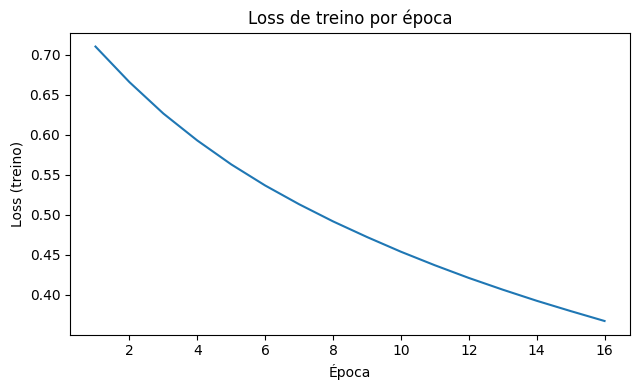

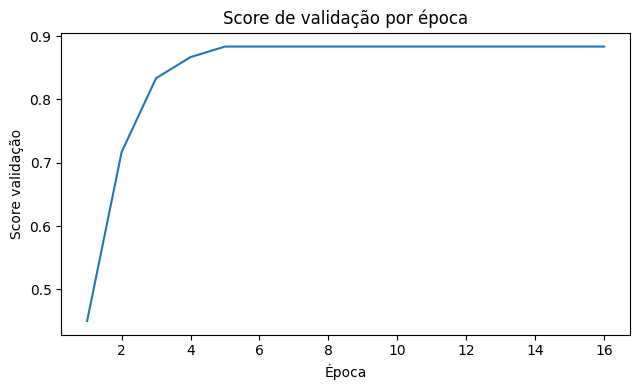

In [6]:

# Para visualizar loss, precisa de warm_start ou acessar loss_curve_
loss_curve = getattr(mlp, "loss_curve_", None)
val_scores = getattr(mlp, "validation_scores_", None)

if loss_curve is not None:
    plt.figure(figsize=(6.5,4))
    plt.plot(range(1, len(loss_curve)+1), loss_curve)
    plt.xlabel("Época"); plt.ylabel("Loss (treino)"); plt.title("Loss de treino por época")
    plt.tight_layout(); plt.show()

if val_scores is not None:
    plt.figure(figsize=(6.5,4))
    plt.plot(range(1, len(val_scores)+1), val_scores)
    plt.xlabel("Época"); plt.ylabel("Score validação"); plt.title("Score de validação por época")
    plt.tight_layout(); plt.show()


## 6) Impacto de hiperparâmetros (gridzinho manual)

In [7]:

configs = [
    {"hls": (8,), "alpha": 1e-4, "act": "relu"},
    {"hls": (32,), "alpha": 1e-4, "act": "relu"},
    {"hls": (32,16), "alpha": 1e-4, "act": "relu"},
    {"hls": (32,16), "alpha": 1e-3, "act": "relu"},
    {"hls": (32,16), "alpha": 1e-4, "act": "tanh"},
]
rows = []
for cfg in configs:
    model = MLPClassifier(hidden_layer_sizes=cfg["hls"], activation=cfg["act"],
                          solver="adam", alpha=cfg["alpha"], batch_size=32,
                          learning_rate="adaptive", learning_rate_init=1e-3,
                          max_iter=300, random_state=42, early_stopping=True,
                          n_iter_no_change=10, validation_fraction=0.1, verbose=False)
    model.fit(X_tr_s, y_tr)
    acc_te = accuracy_score(y_te, model.predict(X_te_s))
    rows.append((cfg["hls"], cfg["act"], cfg["alpha"], acc_te))

pd.DataFrame(rows, columns=["hidden_layer_sizes","activation","alpha","acc_teste"]).sort_values("acc_teste", ascending=False)


,hidden_layer_sizes,activation,alpha,acc_teste
2,"(32, 16)",relu,0.0001,0.915
3,"(32, 16)",relu,0.0010,0.915
1,"(32,)",relu,0.0001,0.900
0,"(8,)",relu,0.0001,0.895
4,"(32, 16)",tanh,0.0001,0.895


## 7) Caso não linear (meia-lua) — onde MLP brilha vs Perceptron

Acurácia — Perceptron (moons): 0.815
Acurácia — MLP (moons):       0.900


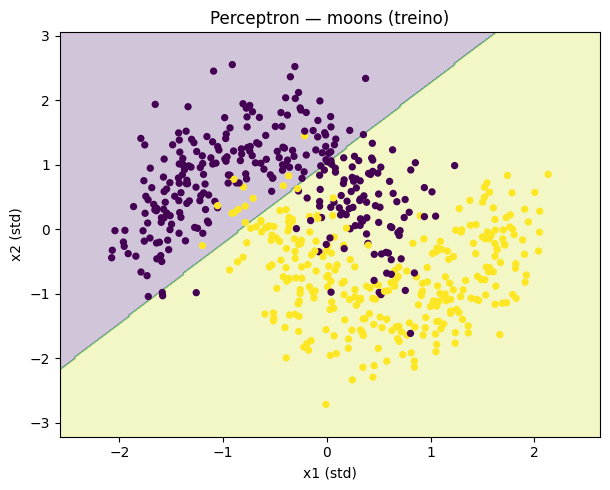

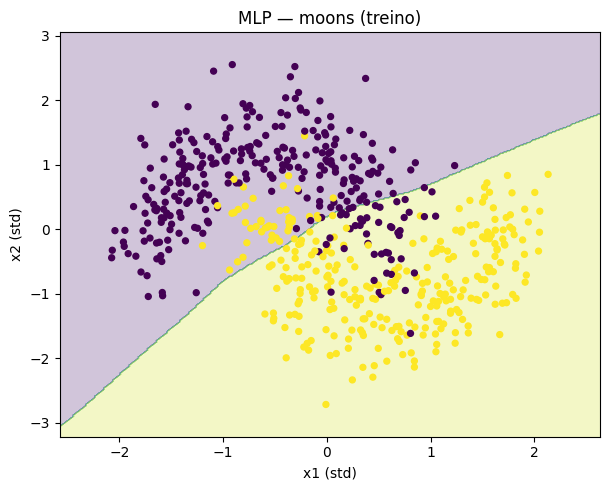

In [8]:

from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=800, noise=0.25, random_state=42)
Xm_tr, Xm_te, ym_tr, ym_te = train_test_split(Xm, ym, test_size=0.25, random_state=42, stratify=ym)
sc_m = StandardScaler()
Xm_tr_s = sc_m.fit_transform(Xm_tr); Xm_te_s = sc_m.transform(Xm_te)

# Perceptron
perc_m = Perceptron(max_iter=1000, tol=1e-3, random_state=42).fit(Xm_tr_s, ym_tr)
acc_pm = accuracy_score(ym_te, perc_m.predict(Xm_te_s))

# MLP
mlp_m = MLPClassifier(hidden_layer_sizes=(32,16), activation="relu",
                      solver="adam", alpha=1e-4, batch_size=32,
                      learning_rate="adaptive", learning_rate_init=1e-3,
                      max_iter=400, random_state=42, early_stopping=True,
                      n_iter_no_change=10, validation_fraction=0.1, verbose=False).fit(Xm_tr_s, ym_tr)
acc_mm = accuracy_score(ym_te, mlp_m.predict(Xm_te_s))

print(f"Acurácia — Perceptron (moons): {acc_pm:.3f}")
print(f"Acurácia — MLP (moons):       {acc_mm:.3f}")

def plot_boundary(model, X, y, title=""):
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.figure(figsize=(6.2,5))
    plt.contourf(xx, yy, Z, alpha=0.25)
    plt.scatter(X[:,0], X[:,1], c=y, s=18)
    plt.title(title); plt.xlabel("x1 (std)"); plt.ylabel("x2 (std)")
    plt.tight_layout(); plt.show()

plot_boundary(perc_m, Xm_tr_s, ym_tr, "Perceptron — moons (treino)")
plot_boundary(mlp_m,  Xm_tr_s, ym_tr, "MLP — moons (treino)")


## 8) Checklist — quando o MLP é uma boa?


- Quando há **não linearidades** claras entre features e target.  
- Quando as features são **numéricas** (ou foram bem representadas/embarcadas).  
- Quando você tem **dados suficientes** para evitar overfitting (use `alpha`/`early_stopping`).  
- Quando quer um baseline poderoso antes de arquiteturas mais profundas/complexas.
